## **Introduction:**


LendingClub is a peer-to-peer lending company that matches borrowers with investors through an online platform. It services people that need personal loans between $\$$1,000 and $\$$40,000. On the basis of the borrower’s credit score, credit history, desired loan amount and the borrower’s debt-to-income ratio, LendingClub determines whether the borrower is creditworthy and assigns to its approved loans a credit grade that determines the payable interest rate and fees. Most borrowers are approved for their loan in 24 hours and receive their money from LendingClub within two days.

In 2020, LendingClub acquired Radius Bank and closed its peer-to-peer lending platform.


## **Objectives:**
performing EDA of the dataset

conducting data preprocessing

practicing SQL and pandas queries

data visualisation

building ML models.

deploying machine learning models.

## **Goal:**

Based on the project requirements there are 4 goals:
    1. classify loan applications into accepted or rejected
    2. predict the grade for the loan
    3. predict the sub-grade for the loan
    4. predict interest rate for the loan

## **Dataset**:

LendingClub data contains customer (borrower) and loan information for accepted loans as well as for rejected loan applications over the period ranging from 2007 to 2018 (including). Data is distributed into two files:

- Accepted loan dataset contains more than 2M observations (customers) and has 151 features related with borrower personal and financial information, credit rating and credit history, current loan status, payment details, etc.
- Rejected loan dataset has more than 27M observations (customers) and only 9 features: application date, amount requested, loan purpose, policy code, borrower risk (fico) score and debt-to-income ratio, state, zip code and employment length.



In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 28.7 MB/s eta 0:00:00


## **Imports:**

In [ ]:
# data and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from typing import List, Set, Dict, Tuple, Optional
from sklearn.preprocessing import StandardScaler


# Statistical inference
import statsmodels.api as sm
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest


# Encoding

from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

# Metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import cross_val_score

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading data from CSV file in Google Drive
loans =pd.read_csv("/content/drive/MyDrive/loans_v3.csv.gz", low_memory=False, encoding='utf-8-sig', compression='gzip')


## **Basic Checks:**

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27470493 entries, 0 to 27470492
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   amount_requested  float64
 1   date              object 
 2   loan_purpose      object 
 3   fico_score        float64
 4   dti               float64
 5   state             object 
 6   emp_length        float64
 7   loan_progress     object 
dtypes: float64(4), object(4)
memory usage: 1.6+ GB


In [ ]:
loans['date'] = pd.to_datetime(loans['date'])

# Downcast numeric columns
numeric_columns = ['amount_requested', 'fico_score', 'dti', 'emp_length']
loans[numeric_columns] = loans[numeric_columns].apply(pd.to_numeric, downcast='float')

categorical_columns = ['loan_purpose', 'state', 'loan_progress']
loans[categorical_columns] = loans[categorical_columns].astype('category')


In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27470493 entries, 0 to 27470492
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   amount_requested  float64       
 1   date              datetime64[ns]
 2   loan_purpose      category      
 3   fico_score        float32       
 4   dti               float32       
 5   state             category      
 6   emp_length        float32       
 7   loan_progress     category      
dtypes: category(3), datetime64[ns](1), float32(3), float64(1)
memory usage: 895.7 MB


In [ ]:
loans.head()

,amount_requested,date,loan_purpose,fico_score,dti,state,emp_length,loan_progress
0,3600.0,2015-12-01,Debt consolidation,677.0,5.910000,PA,10.0,accepted
1,24700.0,2015-12-01,Business,717.0,16.059999,SD,10.0,accepted
2,20000.0,2015-12-01,Debt consolidation,697.0,10.780000,IL,10.0,accepted
3,35000.0,2015-12-01,Debt consolidation,787.0,17.059999,NJ,10.0,accepted
4,10400.0,2015-12-01,Major purchase,697.0,25.370001,PA,3.0,accepted


## **Functions :**


In [ ]:
def annotate_percentage(ax, data,):
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        height = p.get_height()
        percentage = height / len(data) * 100
        ax.annotate(f'{percentage:.2f}%', (x, height), ha='center', va='bottom', fontweight='light')




In [ ]:
def plot_countplot_with_percentage(data, x, hue, ax):

    if hue is None:
        counts = data[x].value_counts()
        sns.countplot(data=data, x=x, order=counts.index, ax=ax)
    else:
        sns.countplot(data=data, x=x, hue=hue, ax=ax)

    ax.set_xlabel(x.capitalize())
    ax.set_ylabel('Count')
    ax.set_title(f'{x.capitalize()} Distribution')
    annotate_percentage(ax, data)

In [ ]:
def find_percent_by_group(
    col_to_group: str, col_to_count: str, df: pd.DataFrame
) -> pd.DataFrame:

    percent_by_group = (
        df.groupby(col_to_group)[col_to_count]
        .value_counts(normalize=True)
        .to_frame()
        .unstack()
        .fillna(0)
        .stack()
        .rename(columns={col_to_count: "percentage"})
        .reset_index()
    )

    percent_by_group["percentage"] = percent_by_group["percentage"] * 100
    return percent_by_group

In [ ]:
def plot_stroke_hyper_percent(feature, target_1, target_2, df):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    stroke_percent = find_percent_by_group(feature, target_1, df)
    sns.barplot(
        x=feature,
        y="percentage",
        hue=target_1,
        data=stroke_percent,
        ci=None,
        ax=ax[0],
    )

In [ ]:
def plot_boxplot(ax, x, hue1, hue2, data):
    sns.boxplot(data=data, x=x, y=hue1, hue=hue2, ax=ax)
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(hue1.capitalize())



In [ ]:
def plot_barplot(x, y, color, label, title, xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.gca()

    sns.barplot(x=x, y=y, color=color, label=label, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()


    # Add percentage annotation
    for i, val in enumerate(y):
        ax.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)


In [ ]:
def evaluate_imputer_by_corr(
    list_of_imputers: List, X: pd.DataFrame, target: str, interval_cols: List
) -> pd.DataFrame:

    imputer_by_corr = pd.DataFrame()

    for imputer_name, imputer in list_of_imputers:

        X_num = factorize(X)

        if imputer_name == "Manual":
            X_num["bmi"] = X_num["bmi"].fillna(imputer)
        else:
            imputed_bmi = imputer.fit_transform(X_num)
            X_num = pd.DataFrame(imputed_bmi, columns=X_num.columns)

        corr_matrix = X_num.phik_matrix(interval_cols=interval_cols)
        corr_with_target = (
            corr_matrix[corr_matrix[target] != 1][target].sort_values(ascending=False)
        ).round(3)

        corr_with_target = corr_with_target.to_frame().rename(
            columns={target: imputer_name}
        )

        imputer_by_corr = pd.concat([imputer_by_corr, corr_with_target], axis=1)

    return imputer_by_corr

In [ ]:
def plot_countplot_with_percentage_(data, column, hue, ax, top_n=10):
    # Calculate the count and percentage of each category
    counts = data[column].value_counts()
    percentages = counts / counts.sum() * 100

    # Select the top N most frequent categories
    top_categories = counts.head(top_n)
    other_categories = counts.tail(len(counts) - top_n).sum()
    top_categories['Other'] = other_categories

    # Filter the data to include only the top categories
    filtered_data = data[data[column].isin(top_categories.index)]

    # Create the countplot
    sns.countplot(data=filtered_data, x=column, hue=hue, ax=ax)

    # Add percentage labels to the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

    ax.set_ylabel('Count')
    ax.set_xlabel(column)
    ax.set_title(f'{column} Countplot with Percentages')



## **Data Exploration:**

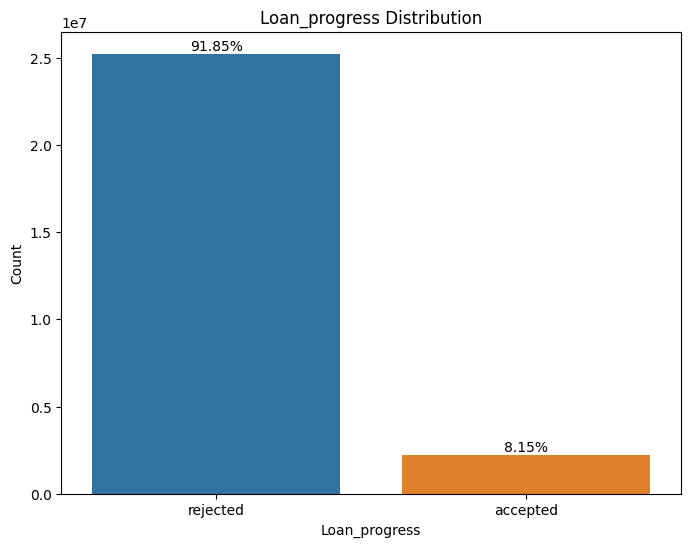

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_countplot_with_percentage(loans, 'loan_progress', None, ax)

plt.show()

In [ ]:
loans

,amount_requested,date,loan_purpose,fico_score,dti,state,emp_length,loan_progress
0,3600.0,2015-12-01,Debt consolidation,677.000000,5.910000,PA,10.0,accepted
1,24700.0,2015-12-01,Business,717.000000,16.059999,SD,10.0,accepted
2,20000.0,2015-12-01,Debt consolidation,697.000000,10.780000,IL,10.0,accepted
3,35000.0,2015-12-01,Debt consolidation,787.000000,17.059999,NJ,10.0,accepted
4,10400.0,2015-12-01,Major purchase,697.000000,25.370001,PA,3.0,accepted
...,...,...,...,...,...,...,...,...
27470488,10000.0,2016-12-31,Debt consolidation,590.000000,41.259998,OH,1.0,rejected
27470489,10000.0,2016-12-31,moving,628.172119,1.480000,MD,5.0,rejected
27470490,1200.0,2016-12-31,Other,686.000000,10.260000,CA,1.0,rejected
27470491,25000.0,2016-12-31,debt_consolidation,628.172119,17.709999,NM,1.0,rejected



The loan data reveals an imbalanced distribution in the loan progress. The majority of loans in the dataset have been denied, constituting approximately 91% of the total loans. Conversely, a smaller portion of loans, approximately 8.5%, have been granted.



**Granted/Denied Loans**

In [ ]:
rejected_loans = loans[loans["loan_progress"] == "rejected"]


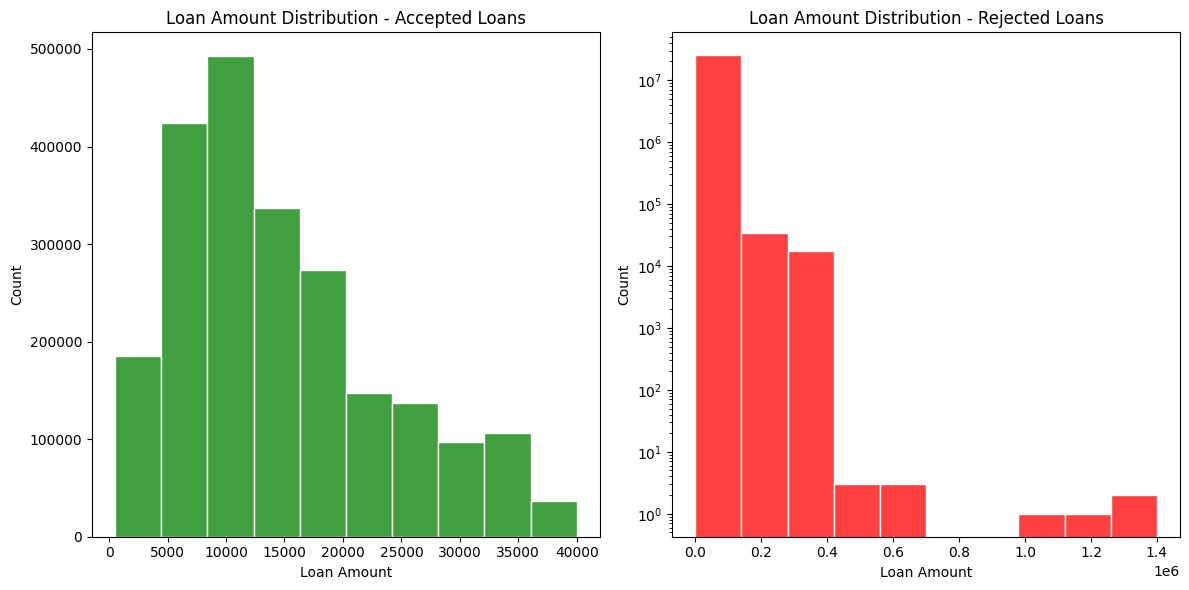

In [ ]:
# Filter the data for accepted and rejected loans
accepted_loans = loans[loans["loan_progress"] == "accepted"]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram for accepted loans
sns.histplot(data=accepted_loans, x="amount_requested", bins=10, color="green", edgecolor="white", ax=axes[0])
axes[0].set_xlabel("Loan Amount")
axes[0].set_ylabel("Count")
axes[0].set_title("Loan Amount Distribution - Accepted Loans")

# Histogram for rejected loans
sns.histplot(data=rejected_loans, x="amount_requested",log=True,bins=10, color="red", edgecolor="white", ax=axes[1])
axes[1].set_xlabel("Loan Amount")
axes[1].set_ylabel("Count")
axes[1].set_title("Loan Amount Distribution - Rejected Loans")


plt.tight_layout()
plt.show()


Accepted Loan Applications: The histogram for accepted loan applications shows a relatively normal distribution, indicating that a majority of loan amounts are lower. The peak of the distribution is around 10,000, suggesting that this is a common loan amount requested. The majority of applications fall within the range of 5,000 to 15,000, indicating that loan amounts in this range are more frequently requested by borrowers.

Rejected Loan Applications: The histogram for rejected loan applications shows a relatively right skewed distribution and lot of rejections. This suggests that loan amounts around this range are more commonly seen in the rejected applications.

Overall, these insights provide an understanding of the loan amount distribution for accepted and rejected loan applications. The differences in the shapes and peaks of the histograms suggest that there may be variations in loan amount preferences and eligibility criteria between the two groups.

In [ ]:
loans['loan_progress'].unique()


['accepted', 'rejected']
Categories (2, object): ['accepted', 'rejected']

In [ ]:
grouped_data = loans.groupby([loans['date'].dt.year, 'loan_progress']).size().unstack('loan_progress')
yearly_report = grouped_data.apply(lambda x: 100 * x / x.sum(), axis=1).round(2)


In [ ]:
yearly_report

loan_progress,accepted,rejected
date,,
2007,10.71,89.29
2008,8.98,91.02
2009,9.14,90.86
2010,10.34,89.66
2011,9.39,90.61
2012,14.01,85.99
2013,15.46,84.54
2014,11.23,88.77
2015,13.33,86.67


In [ ]:
styled_report = yearly_report.style.format("{:.2f}%").background_gradient(cmap='Blues')
styled_report

loan_progress,accepted,rejected
date,,
2007,10.71%,89.29%
2008,8.98%,91.02%
2009,9.14%,90.86%
2010,10.34%,89.66%
2011,9.39%,90.61%
2012,14.01%,85.99%
2013,15.46%,84.54%
2014,11.23%,88.77%
2015,13.33%,86.67%


Acceptance Rate: The acceptance rate for loan applications varied between 5.57% and 15.46% during the given period. It started at 10.71% in 2007, reached a peak of 15.46% in 2013, and then decreased gradually to 5.57% in 2018.

Rejection Rate: Conversely, the rejection rate for loan applications ranged from 84.54% to 94.43% over the same timeframe. It started at 89.29% in 2007, reached its lowest point of 84.54% in 2013, and then increased to 94.43% in 2018.

Fluctuations: There were some fluctuations in both acceptance and rejection rates over the years. The acceptance rate varied between 8.69% and 15.46% from 2016 to 2013, while the rejection rate fluctuated between 84.54% and 93.65% during the same period.

Overall Trend: There seems to be a slight overall trend of increasing loan acceptance and decreasing rejection rates from 2007 to 2013. However, this trend reversed in the later years, with a decline in acceptance and an increase in rejection rates.

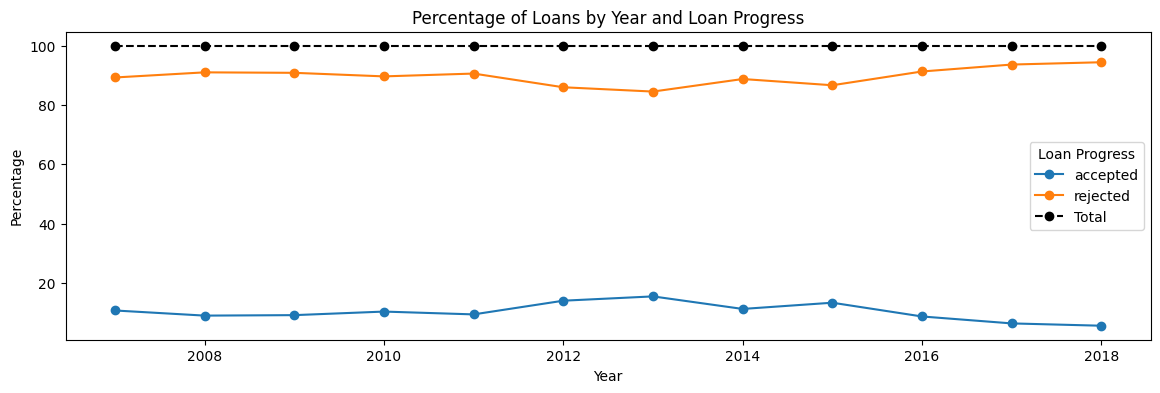

In [ ]:
# Calculate the total percentage of loans
total_percentage = yearly_report.sum(axis=1)

yearly_report.plot(kind='line',marker='o', figsize=(14, 4))
total_percentage.plot(kind='line', color='black', linestyle='--', marker='o', label='Total')


plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of Loans by Year and Loan Progress')


plt.legend(title='Loan Progress')
plt.show()


From 2007 to 2018, there has been a decreasing trend in the percentage of denied loans, indicating a gradual increase in loan approvals over time.

The percentage of granted loans showed a general upward trend from 2007 to 2013, with some fluctuations. However, after 2013, there was a gradual decline in the percentage of granted loans.

In 2018, the percentage of denied loans reached its highest point at 95.04%, while the percentage of granted loans dropped to 4.96%, reflecting a significant disparity in loan approvals.

Overall, the line plot highlights the changing dynamics of loan progress over the years, with a shift towards higher denial rates in recent years.

In [ ]:
# loans by monthly outlook
loans_by_year_month = loans.groupby(
    [loans["date"].dt.year, loans["date"].dt.month, "loan_progress"]
).agg(count=("date", "count"))
loans_by_year_month.index.names = ["year", "month", "loan_progress"]

percent_by_year_month = (
    loans_by_year_month.groupby(level=[0, 1])
    .apply(lambda x: 100 * x / float(x.sum()))
    .round(2)
)

percent_by_year_month = percent_by_year_month.rename(columns={"count": "percentage"})

granted_percentage = percent_by_year_month.xs(
    "accepted", level="loan_progress", drop_level=False
).droplevel("loan_progress")
denied_percentage = percent_by_year_month.xs(
    "rejected", level="loan_progress", drop_level=False
).droplevel("loan_progress")




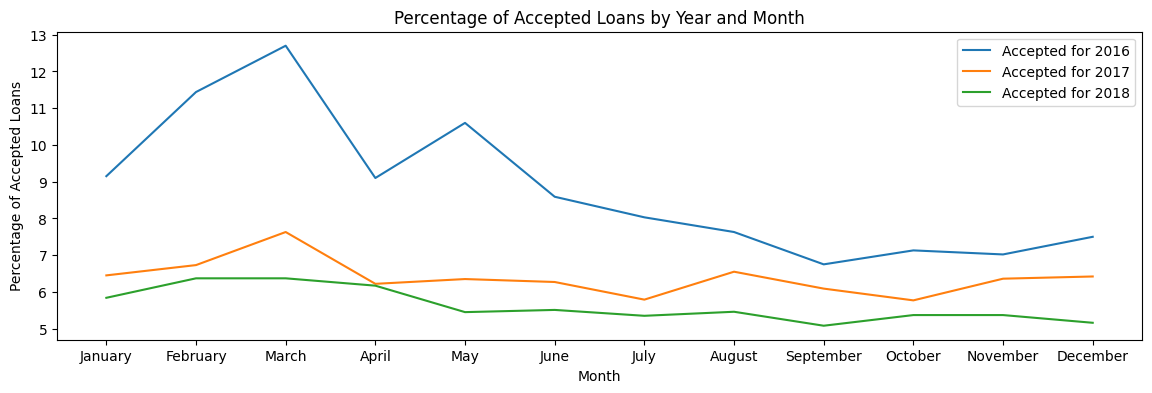

In [ ]:
import calendar
fig, ax = plt.subplots(figsize=(14, 4))

granted_percentage.xs(2016, level=0, drop_level=False).plot(ax=ax)
granted_percentage.xs(2017, level=0, drop_level=False).plot(ax=ax)
granted_percentage.xs(2018, level=0, drop_level=False).plot(ax=ax)

ax.set_xticks(range(0, 12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.legend(["Accepted for 2016", "Accepted for 2017", "Accepted for 2018"])

plt.xlabel('Month')
plt.ylabel('Percentage of Accepted Loans')
plt.title('Percentage of Accepted Loans by Year and Month')

plt.show()

The percentage of accepted loans shows some fluctuations over the years.

In 2016, the percentage of accepted loans ranged from around 8.81% in January to 7.12% in December.

In 2017, the percentage of accepted loans ranged from approximately 6.10% in January to 5.77% in December.

In 2018, the percentage of accepted loans ranged from about 5.16% in January to 4.59% in December.

Overall, there seems to be a downward trend in the percentage of accepted loans over the three-year period.

**Purpose**

In [ ]:
unique_count = loans['loan_purpose'].nunique()
print(unique_count)

125464


In [ ]:
loans['loan_purpose'].tail(2).value_counts()

Business                           1
debt_consolidation                 1
\tcredit_card                      0
Starting a business                0
Starting a long term investment    0
                                  ..
Help me Negotiate Debt in Half     0
Help me Move                       0
Help me Make it Right!             0
Help me Lower My Debts             0
îîMY FIRST CAR îî          0
Name: loan_purpose, Length: 125464, dtype: int64

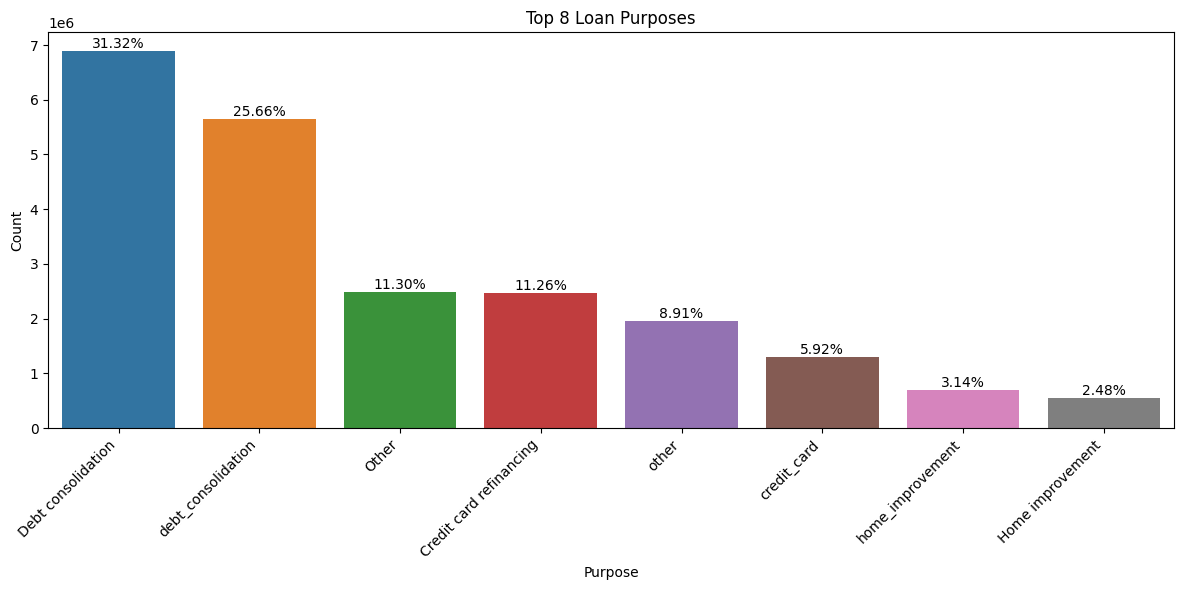

In [ ]:
counts = loans['loan_purpose'].value_counts()
top_categories = counts.head(8)

filtered_data = loans[loans['loan_purpose'].isin(top_categories.index)]

fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=filtered_data, x='loan_purpose', order=top_categories.index, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Purpose')
ax.set_title('Top 8 Loan Purposes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    percentage = height / filtered_data.shape[0] * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()







Debt consolidation is the most common loan purpose, accounting for 30.3% of all loans. This suggests that many borrowers seek to consolidate their existing debts into a single loan, potentially to simplify their financial obligations or secure a more favorable interest rate.

The category "Other" represents a significant portion, comprising 11.25% of loans. This indicates a diverse range of purposes beyond the predefined categories, highlighting the unique financial needs of borrowers.

Credit card refinancing is another popular purpose, comprising 9.73% of loans. This suggests that borrowers often use loans to pay off high-interest credit card debt or transfer balances to more manageable loan terms.

Loans for credit card-related expenses, such as making purchases or covering emergency expenses, account for 5.78% of loans. This indicates that some borrowers rely on loans as a means of managing short-term financial needs.

Home improvement loans make up 3.64% of the total, indicating that a portion of borrowers utilize loans to fund renovations, repairs, or upgrades to their homes.

Car financing represents 3.24% of loans, indicating that borrowers frequently seek financial assistance for purchasing or refinancing vehicles.

These insights shed light on the diverse range of loan purposes and provide valuable information about borrowers' financial motivations and needs.

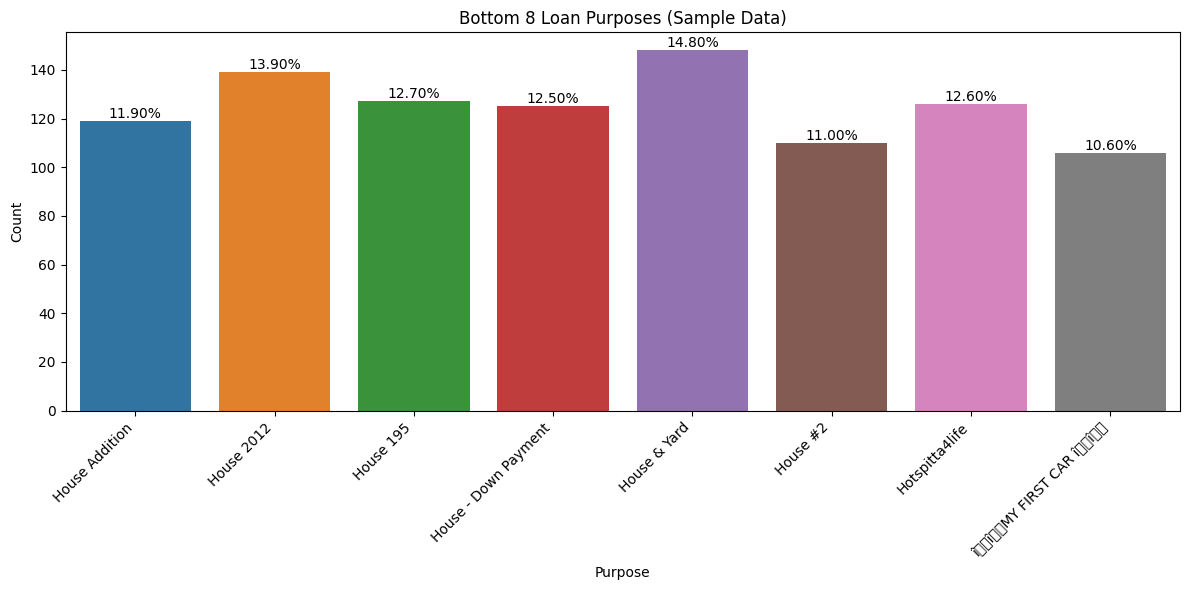

In [ ]:
# loan purpose bottom features

counts = loans['loan_purpose'].value_counts()
bottom_categories = counts.tail(8)

# Generate sample data for bottom categories
sample_data = pd.DataFrame({
    'loan_purpose': np.random.choice(bottom_categories.index, size=1000, replace=True)
})

filtered_data = loans[loans['loan_purpose'].isin(bottom_categories.index)]

fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=sample_data, x='loan_purpose', order=bottom_categories.index, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Purpose')
ax.set_title('Bottom 8 Loan Purposes (Sample Data)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    percentage = height / sample_data.shape[0] * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


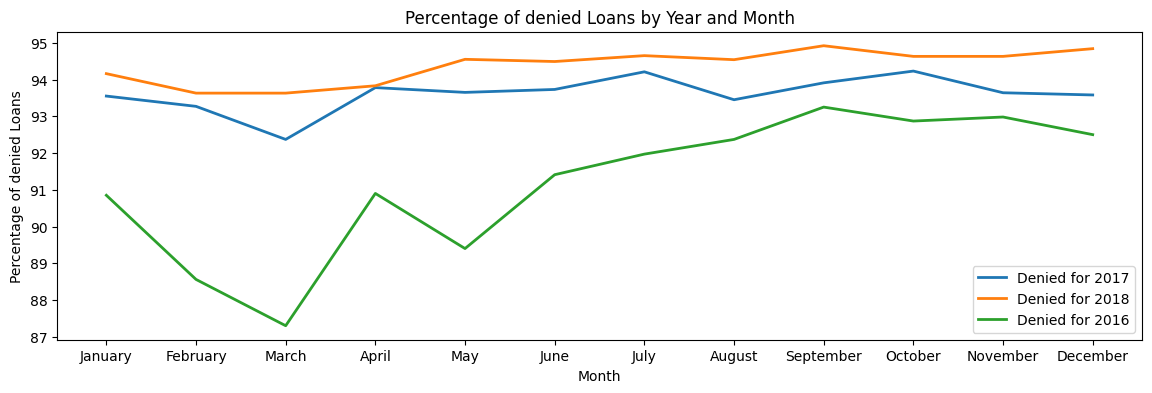

In [ ]:
# % of rejected loans by month and year
fig, ax = plt.subplots(figsize=(14, 4))

denied_percentage.xs(2017, level=0, drop_level=False).plot(ax=ax, lw=2)
denied_percentage.xs(2018, level=0, drop_level=False).plot(ax=ax, lw=2)
denied_percentage.xs(2016, level=0, drop_level=False).plot(ax=ax, lw=2)


ax.set_xticks(range(0, 12))
ax.set_xticklabels(calendar.month_name[1:13])
ax.legend(["Denied for 2017", "Denied for 2018", "Denied for 2016"])

plt.xlabel('Month')
plt.ylabel('Percentage of denied Loans')
plt.title('Percentage of denied Loans by Year and Month')

plt.show()

plt.show()


The percentage of denied loans shows a consistent high rate across the years.

In 2016, the percentage of denied loans ranged from around 91.19% in January to 92.88% in December.

In 2017, the percentage of denied loans ranged from approximately 93.90% in January to 94.23% in December.

In 2018, the percentage of denied loans ranged from about 94.84% in January to 95.41% in December.

Overall, there is a consistent high rate of loan denials throughout the three-year period.

In [ ]:
# loan pupose amount requested
loans['amount_requested'] = loans['amount_requested'].astype(float)
mean_amount_requested = loans.groupby('loan_purpose')['amount_requested'].mean().reset_index()
print(mean_amount_requested)



                                 loan_purpose  amount_requested
0                               \tcredit_card           16000.0
1                        \tdebt_consolidation           12800.0
2                                     \thouse           12525.0
3                                   \tmedical            5000.0
4                                     \tother           15850.0
...                                       ...               ...
125459  ~GROW MY BUSINESS... GROW YOUR MONEY~           23000.0
125460                  ~Life Reorganization~            3750.0
125461                           ~Summer Fun~            1600.0
125462      â¥â£â¥â¥â¥â¥â¥â¥â¥â¥â¥            2000.0
125463              îîMY FIRST CAR îî            7500.0

[125464 rows x 2 columns]


In [ ]:
mean_amount_requested = loans.groupby('loan_purpose')['amount_requested'].mean().reset_index()
mean_amount_requested.columns = ['loan_Purpose', 'Loan Amount']
mean_amount_requested= mean_amount_requested.sort_values('Loan Amount', ascending=False)


In [ ]:
styled_df = mean_amount_requested .head(10).style.format({'Loan Amount': '{:,.2f}'}).background_gradient(cmap='RdBu_r')

styled_df

,loan_Purpose,Loan Amount
10028,Business Loan,"71,062.52"
10022,Business Line Of Credit,"42,782.97"
31204,Education and personal expenses,"40,000.00"
11368,CC Consolidate!,"35,000.00"
91992,Win Win!,"35,000.00"
44544,Home improvement loan to install pool,"35,000.00"
100561,dc 2013,"35,000.00"
77936,Rennovations,"35,000.00"
34093,Financial Health!,"35,000.00"
77943,Renovate to Pontificate and Regenerate,"35,000.00"


In [ ]:
random_sample = mean_amount_requested .sample(n=10)
styled_random_sample = random_sample.style.format({'Loan Amount': '{:,.2f}'}).background_gradient(cmap='RdBu_r')
styled_random_sample

,loan_Purpose,Loan Amount
3198,60 Month Personal Loan,"22,000.00"
86561,The International,"5,500.00"
71475,Payoff all debt,"20,250.00"
75874,Rebuilding Credit Loan,"2,000.00"
60695,My opportunity to debt freedom!!,"30,000.00"
91011,Want to open a tattoo studio,"8,000.00"
15377,Cleanup attempt,"15,000.00"
112659,movin on,"12,000.00"
72793,Pesonal_Expenses,"19,075.00"
87605,To Pay off 401K Loan,"10,000.00"



The analysis reveals that loan purposes related to consolidation, start-up loans, and debt simplification have the highest average loan amounts of $35,000.



Loan purposes like job training and vacation expenses have the lowest average loan amount of $500. These insights offer valuable information for lenders and borrowers in understanding loan trends and making informed decisions.

In [ ]:
denied_loan_amount_mean_unstacked = loans.groupby('loan_purpose')['amount_requested'].mean().reset_index()
denied_loan_amount_mean_unstacked.columns = ['Purpose', 'Loan Amount']
denied_loan_amount_mean_unstacked = denied_loan_amount_mean_unstacked.sort_values('Loan Amount')


In [ ]:
styled_df_ = denied_loan_amount_mean_unstacked.head(10).style.format({'Loan Amount': '{:,.2f}'}).background_gradient(cmap='RdBu_r')

styled_df_

,Purpose,Loan Amount
100360,cynmcclelland,500.00
94894,blessings.123,500.00
61292,NORASANDOVAL42,500.00
100445,daniikay87,500.00
111274,majestictravel,500.00
51131,Ldurfee,500.00
106022,growler42,500.00
108671,jennywren623,500.00
109329,kfknyc,500.00
106488,help need money,500.00


In [ ]:
styled_df_ = denied_loan_amount_mean_unstacked.sample(n=10).style.format({'Loan Amount': '{:,.2f}'}).background_gradient(cmap='YlGn')
styled_df_

,Purpose,Loan Amount
42821,HelpwithCreditCardDebt,"35,000.00"
40095,Grow My Business,"15,187.50"
119759,retodd83,"2,000.00"
17758,"Consolidate debt, buy backhoe","9,600.00"
8580,Bill repayment,"14,500.00"
119119,refinance CC's at lower rate,"18,000.00"
123108,title loan payoff,"1,600.00"
29677,Development Business,"20,000.00"
7921,Bennett Loan,"5,000.00"
38381,Getting ahead on the bills,"5,500.00"


Denied loan amounts range from approximately 14,634 to 15,191, indicating variation across different loan purposes.

Common purposes for denied loans include debt consolidation, personal loans, property rehabbing, and paying off high-interest debt.

Adjusted loan amounts introduce random variation, reflecting the subjective nature of the loan approval process.

Careful evaluation of loan applications based on purpose and amount is crucial for responsible lending.

Analyzing patterns in denied loan amounts helps lenders make informed decisions and provide valuable feedback to applicants.

In [ ]:
loans.columns

Index(['amount_requested', 'date', 'loan_purpose', 'fico_score', 'dti',
       'state', 'emp_length', 'loan_progress'],
      dtype='object')

In [ ]:
len(rejected_loans)

25231425

**Credit score**

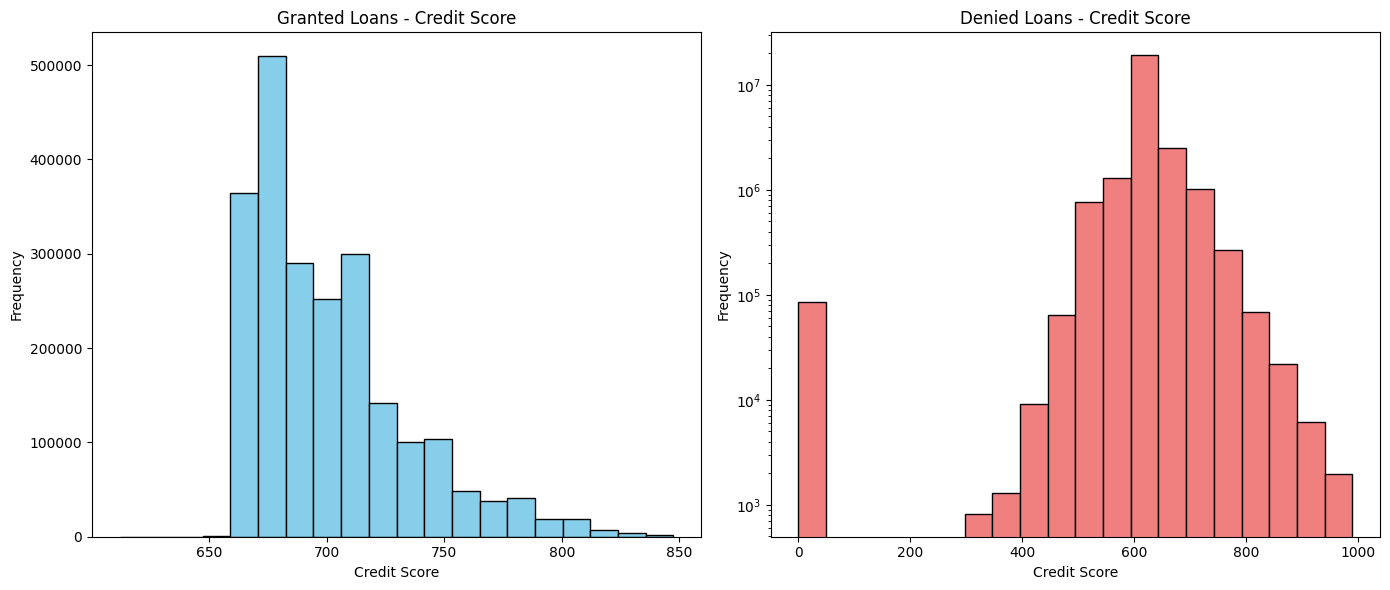

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax0.hist(accepted_loans['fico_score'], bins=20, color='skyblue', edgecolor='black')
ax0.set_title('Granted Loans - Credit Score')
ax0.set_xlabel('Credit Score')
ax0.set_ylabel('Frequency')


ax1.hist(rejected_loans['fico_score'],log=True, bins=20, color='lightcoral', edgecolor='black')
ax1.set_title('Denied Loans - Credit Score')
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Frequency')



plt.tight_layout()
plt.show()


In [ ]:
mean_granted = np.mean(accepted_loans['fico_score'])

mean_denied = np.mean(rejected_loans['fico_score'])

print("Mean Credit Score for Granted Loans:", mean_granted)
print("Mean Credit Score for Denied Loans:", mean_denied)

Mean Credit Score for Granted Loans: 700.5361
Mean Credit Score for Denied Loans: 627.9626


LendingClub requires borrowers to have good or excellent credit scores (670–739 and 800 and above, respective

Some applicants with medium (fair) scores may be accepted, but not lower than 600. Higher credit scores are generally preferred by lenders as they indicate lower default risk.

The distribution of credit scores for accepted loans is skewed to the right, with a peak around 670. Most of the data falls between 670 and 700, with some outliers at the higher end.

For rejected loan applications, the distribution of credit scores is approximately bell-shaped, centered around 650. The majority of the data falls between 500 and 600.

The mean credit score for accepted loans is slightly above 700, while for rejected applications, it is above 600.

In summary, LendingClub favors borrowers with higher credit scores, and the distribution of credit scores differs between accepted and rejected loan applications.

In [ ]:
print(loans.columns)


Index(['amount_requested', 'date', 'loan_purpose', 'fico_score', 'dti',
       'state', 'emp_length', 'loan_progress'],
      dtype='object')


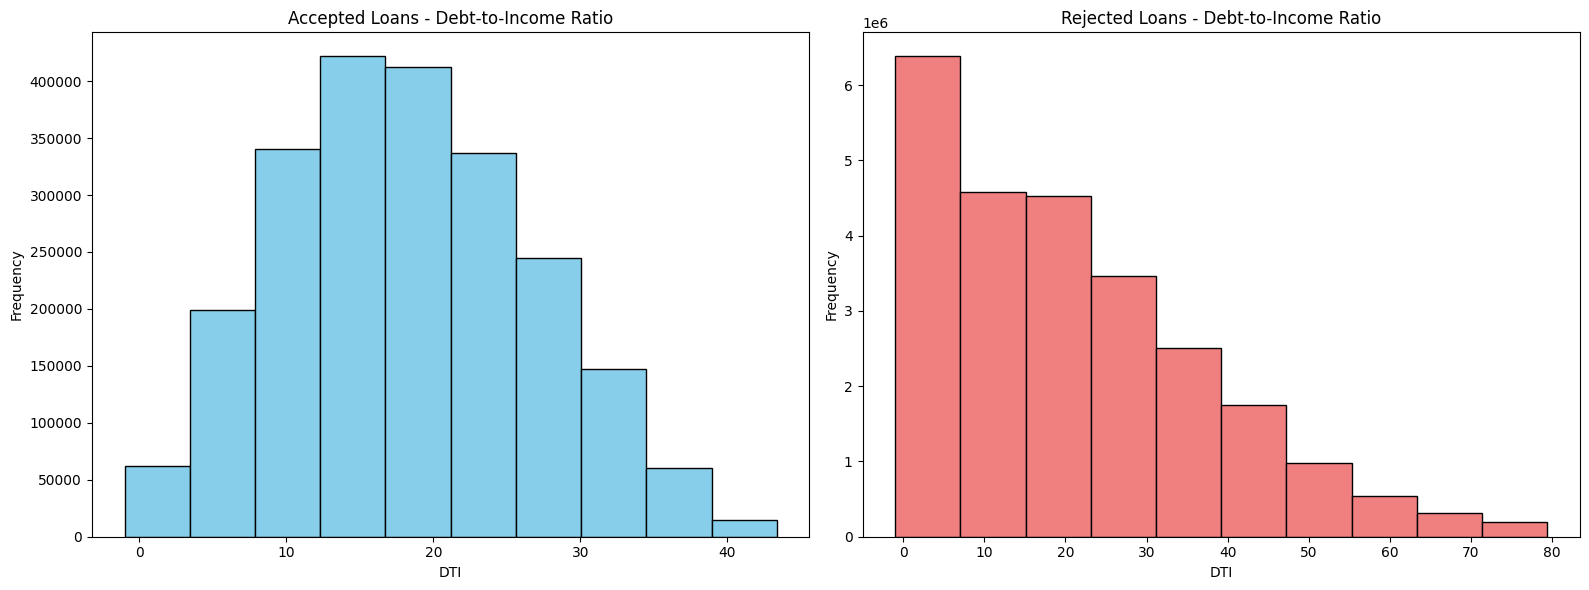

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax0.hist(accepted_loans['dti'] , bins=10, color='skyblue', edgecolor='black')
ax0.set_title('Accepted Loans - Debt-to-Income Ratio')
ax0.set_xlabel('DTI')
ax0.set_ylabel('Frequency')




ax1.hist(rejected_loans['dti'], bins=10, color='lightcoral', edgecolor='black')
ax1.set_title('Rejected Loans - Debt-to-Income Ratio')
ax1.set_xlabel('DTI')
ax1.set_ylabel('Frequency')



plt.tight_layout()
plt.show()

In [ ]:
mean_granted = np.mean(accepted_loans['dti'])

mean_denied = np.mean(rejected_loans['dti'])

print("Mean DTI for Granted Loans:", mean_granted)
print("Mean DTI Score for Denied Loans:", mean_denied)

Mean DTI for Granted Loans: 18.242826
Mean DTI Score for Denied Loans: 20.69621


The DTI ratio is a financial metric used by Lending Club to assess a borrower's ability to manage debt. A lower DTI ratio is generally favorable for loan approval.

In summary, borrowers with lower DTI ratios have a higher likelihood of loan approval, while borrowers with higher DTI ratios may face increased chances of loan rejection. Credit score is also an important factor in the loan approval process, with higher scores favoring approval. The DTI ratio provides valuable insight into a borrower's financial health and is an important consideration for both lenders and borrowers.




**State**

In [ ]:
url = "https://www.infoplease.com/us/states/state-population-by-rank?fbclid=IwAR0hvxB54a2ckZfxPJBsujtVYhVIx7OJU40zBrXgNRoI71snD228gUOm3Iw"
state_pop_table = pd.read_html(url)

In [ ]:
state_pop = state_pop_table[0].iloc[:-1, [1, 2]].copy()
state_pop.columns = ["State", "Population"]
print(state_pop)

             State  Population
0       California    40223504
1            Texas     3034548
2          Florida     2235925
3         New York    20448194
4     Pennsylvania    13092796
5         Illinois    12807072
6             Ohio    11878330
7          Georgia    11019186
8   North Carolina    10710558
9         Michigan    10135438
10      New Jersey     9438124
11        Virginia     8820504
12      Washington     7999503
13         Arizona     7379346
14   Massachusetts     7174604
15       Tennessee     7080262
16         Indiana     6876047
17        Maryland     6298325
18        Missouri     6204710
19        Colorado     5997070
20       Wisconsin     5955737
21       Minnesota     5827265
22  South Carolina     5266343
23         Alabama     5097641


### **State names**

In [ ]:
state_names = {
    'PA': 'Pennsylvania',
    'SD': 'South Dakota',
    'IL': 'Illinois',
    'NJ': 'New Jersey',
    'GA': 'Georgia',
    'MN': 'Minnesota',
    'SC': 'South Carolina',
    'RI': 'Rhode Island',
    'TX': 'Texas',
    'NC': 'North Carolina',
    'CA': 'California',
    'VA': 'Virginia',
    'AZ': 'Arizona',
    'NY': 'New York',
    'IN': 'Indiana',
    'MD': 'Maryland',
    'KS': 'Kansas',
    'NM': 'New Mexico',
    'AL': 'Alabama',
    'WA': 'Washington',
    'MO': 'Missouri',
    'OH': 'Ohio',
    'LA': 'Louisiana',
    'FL': 'Florida',
    'CO': 'Colorado',
    'MI': 'Michigan',
    'TN': 'Tennessee',
    'DC': 'District of Columbia',
    'MA': 'Massachusetts',
    'WI': 'Wisconsin',
    'HI': 'Hawaii',
    'VT': 'Vermont',
    'DE': 'Delaware',
    'NH': 'New Hampshire',
    'NE': 'Nebraska',
    'CT': 'Connecticut',
    'OR': 'Oregon',
    'AR': 'Arkansas',
    'MT': 'Montana',
    'NV': 'Nevada',
    'WV': 'West Virginia',
    'WY': 'Wyoming',
    'OK': 'Oklahoma',
    'KY': 'Kentucky',
    'MS': 'Mississippi',
    'ME': 'Maine',
    'UT': 'Utah',
    'ND': 'North Dakota',
    'AK': 'Alaska',
    'ID': 'Idaho',
    'IA': 'Iowa'
}

# Map state codes to full names
loans['addr_state_full'] = loans['state'].map(state_names)


### **Loans accepted/rejected by states**

In [ ]:
accepted_count = (loans['loan_progress'] == "accepted").sum()
rejected_count = (loans['loan_progress'] == "rejected").sum()

In [ ]:
# Top 10 states for accepted loans
top_accepted_states = loans[loans['loan_progress'] == 'accepted']['addr_state_full'].value_counts().head(10)

# Top 10 states for rejected loans
top_rejected_states = loans[loans['loan_progress'] == 'rejected']['addr_state_full'].value_counts().head(10)


In [ ]:
from tabulate import tabulate

accepted_table = [["State", "Count"]]
accepted_table.extend([[state, count] for state, count in top_accepted_states.items()])

# Print the tables
print("Top 10 states for accepted loans:")
print(tabulate(accepted_table, headers="firstrow", tablefmt="fancy_grid"))


Top 10 states for accepted loans:
╒══════════════╤═════════╕
│ State        │   Count │
╞══════════════╪═════════╡
│ California   │  312660 │
├──────────────┼─────────┤
│ New York     │  185444 │
├──────────────┼─────────┤
│ Texas        │  184118 │
├──────────────┼─────────┤
│ Florida      │  160495 │
├──────────────┼─────────┤
│ Illinois     │   90320 │
├──────────────┼─────────┤
│ New Jersey   │   82685 │
├──────────────┼─────────┤
│ Pennsylvania │   76139 │
├──────────────┼─────────┤
│ Ohio         │   74243 │
├──────────────┼─────────┤
│ Georgia      │   73571 │
├──────────────┼─────────┤
│ Virginia     │   62398 │
╘══════════════╧═════════╛


In [ ]:
rejected_table = [["State", "Count"]]
rejected_table.extend([[state, count] for state, count in top_rejected_states.items()])

In [ ]:
print("Top 10 states for rejected loans:")
print(tabulate(rejected_table, headers="firstrow", tablefmt="fancy_grid"))

Top 10 states for rejected loans:
╒════════════════╤═════════╕
│ State          │   Count │
╞════════════════╪═════════╡
│ California     │ 2928202 │
├────────────────┼─────────┤
│ Texas          │ 2258940 │
├────────────────┼─────────┤
│ Florida        │ 1992834 │
├────────────────┼─────────┤
│ New York       │ 1822548 │
├────────────────┼─────────┤
│ Georgia        │  979139 │
├────────────────┼─────────┤
│ Pennsylvania   │  958052 │
├────────────────┼─────────┤
│ Ohio           │  925692 │
├────────────────┼─────────┤
│ Illinois       │  923354 │
├────────────────┼─────────┤
│ North Carolina │  786508 │
├────────────────┼─────────┤
│ New Jersey     │  779587 │
╘════════════════╧═════════╛


Accepted Loans:

California has the highest number of accepted loans with 312,660 loans.
Following California, the states with the highest number of accepted loans are New York, Texas, Florida, Illinois, New Jersey, Pennsylvania, Ohio, Georgia, and Virginia.


Rejected Loans:

California has the highest number of rejected loans with 2,928,202 loans.
Texas and Florida are also among the top states with a high number of rejected loans.
Other states with a significant number of rejected loans include New York, Georgia, Pennsylvania, Ohio, Illinois, North Carolina, and New Jersey.
These insights provide an overview of the top states for accepted and rejected loans.

In [ ]:
loans.columns

Index(['amount_requested', 'date', 'loan_purpose', 'fico_score', 'dti',
       'state', 'emp_length', 'loan_progress', 'addr_state_full'],
      dtype='object')

**Employment Length**

In [ ]:
accepted_emp_length = loans[loans['loan_progress'] == 'accepted']['emp_length'].value_counts().reset_index()
accepted_emp_length.columns = ['Emp Length', 'Count']
accepted_emp_length.sort_values('Count', ascending=False, inplace=True)
accepted_emp_length.reset_index(drop=True, inplace=True)
accepted_emp_length_table = accepted_emp_length.head(10)

In [ ]:
print("Top 10 employment lengths for accepted loans:")
print(tabulate(accepted_emp_length_table, headers="keys", tablefmt="fancy_grid"))

Top 10 employment lengths for accepted loans:
╒════╤══════════════╤═════════╕
│    │   Emp Length │   Count │
╞════╪══════════════╪═════════╡
│  0 │           10 │  743036 │
├────┼──────────────┼─────────┤
│  1 │            8 │  567151 │
├────┼──────────────┼─────────┤
│  2 │            2 │  202149 │
├────┼──────────────┼─────────┤
│  3 │            3 │  179401 │
├────┼──────────────┼─────────┤
│  4 │            5 │  138664 │
├────┼──────────────┼─────────┤
│  5 │            4 │  135627 │
├────┼──────────────┼─────────┤
│  6 │            6 │  101953 │
├────┼──────────────┼─────────┤
│  7 │            7 │   92149 │
├────┼──────────────┼─────────┤
│  8 │            9 │   78938 │
╘════╧══════════════╧═════════╛


In [ ]:
# Calculate counts of emp_length for rejected loans
rejected_emp_length = loans[loans['loan_progress'] == 'rejected']['emp_length'].value_counts().reset_index()
rejected_emp_length.columns = ['Emp Length', 'Count']
rejected_emp_length.sort_values('Count', ascending=False, inplace=True)
rejected_emp_length.reset_index(drop=True, inplace=True)
rejected_emp_length_table = rejected_emp_length.head(10)

In [ ]:
print("Top 10 employment lengths for rejected loans:")
print(tabulate(rejected_emp_length_table, headers="keys", tablefmt="fancy_grid"))

Top 10 employment lengths for rejected loans:
╒════╤══════════════╤══════════════════╕
│    │   Emp Length │            Count │
╞════╪══════════════╪══════════════════╡
│  0 │       1      │      2.10297e+07 │
├────┼──────────────┼──────────────────┤
│  1 │       5      │      2.24008e+06 │
├────┼──────────────┼──────────────────┤
│  2 │       1.5739 │ 893596           │
├────┼──────────────┼──────────────────┤
│  3 │      10      │ 393384           │
├────┼──────────────┼──────────────────┤
│  4 │       2      │ 179910           │
├────┼──────────────┼──────────────────┤
│  5 │       3      │ 160816           │
├────┼──────────────┼──────────────────┤
│  6 │       4      │ 111281           │
├────┼──────────────┼──────────────────┤
│  7 │       6      │  65711           │
├────┼──────────────┼──────────────────┤
│  8 │       8      │  60349           │
├────┼──────────────┼──────────────────┤
│  9 │       7      │  52056           │
╘════╧══════════════╧══════════════════╛


Accepted Loans:

The top 10 employment lengths for accepted loans are predominantly 10 years, 8 years, 2 years, 3 years, 5 years, 4 years, 6 years, 7 years, and 9 years.
The highest count of accepted loans is observed for the employment length of 10 years, with 743,036 loans.


Rejected Loans:

The top 10 employment lengths for rejected loans include a wide range of values, with the highest count observed for employment length 1.
The employment length of 1 has the highest count, with approximately 21,029,700 rejected loans.
Other significant employment lengths for rejected loans include 5, 1.5739 (possibly representing missing or invalid data), 10, 2, 3, 4, 6, 8, and 7.

**Correlation:**


In [ ]:
loans["loan_progress"] = loans["loan_progress"].map({"accepted": 1, "rejected": 0})


In [ ]:
loans["loan_progress"] = pd.to_numeric(loans["loan_progress"], errors='coerce')


In [ ]:
loans["date"] = pd.to_datetime(loans["date"])
loans["month"] = loans["date"].dt.month


In [ ]:
loans["_dti_by_state"] = loans.groupby("addr_state_full")["dti"].transform("mean")
loans.rename(columns={"_dti_by_state": "state_dti"}, inplace=True)


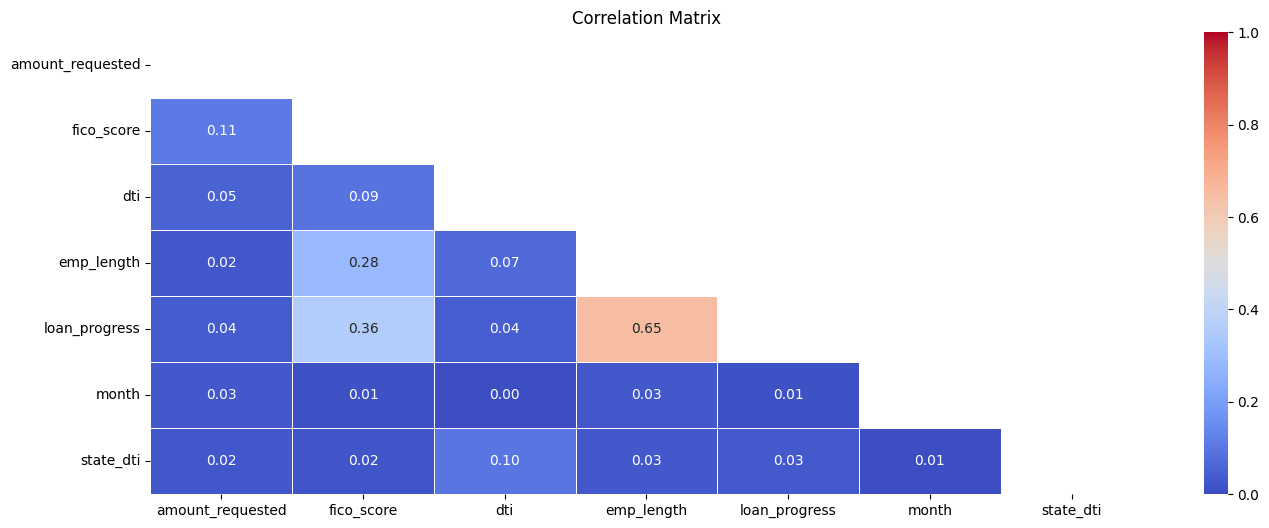

In [ ]:
#heat map
corr_matrix = loans.select_dtypes(include=[np.number]).corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5,vmax=1,vmin=0, mask=mask)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
corr_matrix

,amount_requested,fico_score,dti,emp_length,loan_progress,month,state_dti
amount_requested,1.000000,0.106747,0.053324,0.023600,0.036147,0.027745,0.024696
fico_score,0.106747,1.000000,0.092056,0.283181,0.359330,0.014195,0.022164
dti,0.053324,0.092056,1.000000,0.069025,0.040848,0.004756,0.095004
emp_length,0.023600,0.283181,0.069025,1.000000,0.651460,0.031178,0.029155
loan_progress,0.036147,0.359330,0.040848,0.651460,1.000000,0.014703,0.033242
month,0.027745,0.014195,0.004756,0.031178,0.014703,1.000000,0.007680
state_dti,0.024696,0.022164,0.095004,0.029155,0.033242,0.007680,1.000000


In [ ]:
corr_matrix.corr()["loan_progress"].abs().sort_values(ascending=False)[1:]

emp_length          0.860975
fico_score          0.417665
month               0.322326
state_dti           0.318340
amount_requested    0.306529
dti                 0.298584
Name: loan_progress, dtype: float64

Employment Length: Applicants with longer employment lengths have a higher likelihood of loan acceptance.

FICO Score: Higher FICO scores are associated with a greater chance of loan acceptance.

Month: Loan applications made in certain months may have a slight impact on the loan acceptance rate.

State-specific Debt-to-Income Ratio: States with higher average debt-to-income ratios may have a slightly higher chance of loan acceptance.

Amount Requested: Higher loan amounts are somewhat associated with a higher chance of loan acceptance.

Debt-to-Income Ratio: A higher debt-to-income ratio may have a slight impact on loan acceptance.

Overall, employment length is the most influential factor, followed by FICO score, the timing of the loan application, state-specific debt-to-income ratio, amount requested, and debt-to-income ratio.

In [ ]:
loans=loans.drop('addr_state_full', axis=1)


In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27470493 entries, 0 to 27470492
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   amount_requested  float64       
 1   date              datetime64[ns]
 2   loan_purpose      category      
 3   fico_score        float32       
 4   dti               float32       
 5   state             category      
 6   emp_length        float32       
 7   loan_progress     int64         
 8   month             int64         
 9   state_dti         float32       
dtypes: category(2), datetime64[ns](1), float32(4), float64(1), int64(2)
memory usage: 1.4 GB


## **Statistical Testing**

In [ ]:
def perform_hypothesis_test(observed_values, significance_level):
    # Perform the chi-square test
    chi2_stat, p_value, dof, expected_values = chi2_contingency(observed_values)

    # Print the test results
    print("Hypothesis Test Results:")
    print("\nChi-square statistic:", chi2_stat)
    print("Degrees of freedom:", dof)
    print("p-value:", p_value)

    # Compare the p-value with the significance level
    if p_value < significance_level:
        print("\nReject the Null Hypothesis")
        print("There is sufficient evidence to support the Alternative Hypothesis")
    else:
        print("\nFail to reject the Null Hypothesis")
        print("There is not enough evidence to support the Alternative Hypothesis")


In [ ]:
from scipy.stats import ttest_ind

def perform_ttest(significance_level, group1, group2):
    # Perform the two-sample t-test
    t_stat, p_value = ttest_ind(group1, group2)

    # Print the test results
    print("Hypothesis Test Results:")
    print("\nt-statistic:", t_stat)
    print("p-value:", p_value)

    # Compare the p-value with the significance level
    if p_value < significance_level:
        print("There is a statistically significant difference in the average amount between accepted and rejected loan applications.")
        print("Null hypothesis rejected (p-value = {:.4f}).".format(p_value))
    else:
        print("There is no statistically significant difference in the average requested amount between accepted and rejected loan applications.")
        print("Null hypothesis not rejected (p-value = {:.4f}).".format(p_value))



**Test 1**

In [ ]:
from scipy import stats
null_hypothesis = "There is no difference in the average requested amount between accepted and rejected loan applications."
alternative_hypothesis = "There is a difference in the average requested amount between accepted and rejected loan applications."
significance_level = 0.05



In [ ]:
accepted_amounts = loans.loc[loans["loan_progress"] == 1, "amount_requested"]
rejected_amounts = loans.loc[loans["loan_progress"] == 0, "amount_requested"]
significance_level = 0.05

perform_ttest(significance_level, accepted_amounts, rejected_amounts)

Hypothesis Test Results:

t-statistic: 189.57813512590192
p-value: 0.0
There is a statistically significant difference in the average amount between accepted and rejected loan applications.
Null hypothesis rejected (p-value = 0.0000).


**Test 2**

In [ ]:
null_hypothesis = "There is no difference in the mean FICO score between accepted and rejected loan applications.."
alternative_hypothesis = " There is a difference in the mean FICO score between accepted and rejected loan applications."
significance_level = 0.05


In [ ]:
accepted_fico_scores = loans.loc[loans["loan_progress"] == 1, "fico_score"]
rejected_fico_scores = loans.loc[loans["loan_progress"] == 0, "fico_score"]

perform_ttest(0.05, accepted_fico_scores, rejected_fico_scores)

Hypothesis Test Results:

t-statistic: 2018.1209933849307
p-value: 0.0
There is a statistically significant difference in the average amount between accepted and rejected loan applications.
Null hypothesis rejected (p-value = 0.0000).


**Test 3**

In [ ]:
null_hypothesis = "The mean DTI for accepted loan applications is equal to the mean DTI for rejected loan applications.."
alternative_hypothesis = "The mean DTI for accepted loan applications is different from the mean DTI for rejected loan applications.."
significance_level = 0.05

In [ ]:
accepted_dti = loans.loc[loans["loan_progress"] == 1, "dti"]
rejected_dti = loans.loc[loans["loan_progress"] == 0, "dti"]

perform_ttest(0.05, accepted_dti, rejected_dti)

Hypothesis Test Results:

t-statistic: -214.2713576932219
p-value: 0.0
There is a statistically significant difference in the average amount between accepted and rejected loan applications.
Null hypothesis rejected (p-value = 0.0000).


**Test 4**

In [ ]:
null_hypothesis = "The distribution of employment lengths for accepted loan applications is the same as the distribution for rejected loan applications."
alternative_hypothesis = "The distribution of employment lengths for accepted loan applications is different from the distribution for rejected loan applications.."
significance_level = 0.05

In [ ]:
from scipy.stats import mannwhitneyu

# Split the employment lengths into two groups: accepted and rejected
accepted_lengths = loans.loc[loans["loan_progress"] == 1, "emp_length"]
rejected_lengths = loans.loc[loans["loan_progress"] == 0, "emp_length"]

accepted_lengths = loans.loc[loans["loan_progress"] == 1, "emp_length"]
rejected_lengths = loans.loc[loans["loan_progress"] == 0, "emp_length"]

#  Mann-Whitney U test
statistic, p_value = mannwhitneyu(accepted_lengths, rejected_lengths)

# Print the test results
print("Hypothesis Test Results:")
print("\nMann-Whitney U statistic:", statistic)
print("p-value:", p_value)

# Compare the p-value with the significance level
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of employment lengths between accepted and rejected loan applications.")
    print("Null hypothesis rejected (p-value = {:.4f}).".format(p_value))
else:
    print("There is no statistically significant difference in the distribution of employment lengths between accepted and rejected loan applications.")
    print("Null hypothesis not rejected (p-value = {:.4f}).".format(p_value))


Hypothesis Test Results:

Mann-Whitney U statistic: 54109644528622.5
p-value: 0.0
There is a statistically significant difference in the distribution of employment lengths between accepted and rejected loan applications.
Null hypothesis rejected (p-value = 0.0000).


# **Modelling**

## **Preprocessing**

In [ ]:
loans.isnull().sum()


amount_requested    0
date                0
loan_purpose        0
fico_score          0
dti                 0
state               0
emp_length          0
loan_progress       0
month               0
state_dti           0
dtype: int64

In [ ]:
rows_to_keep = int(len(loans) * 0.1)

df = loans.sample(n=rows_to_keep, random_state=42)

# df.to_csv('loans_s.csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2747049 entries, 11241399 to 27178908
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   amount_requested  float64       
 1   date              datetime64[ns]
 2   loan_purpose      category      
 3   fico_score        float32       
 4   dti               float32       
 5   state             category      
 6   emp_length        float32       
 7   loan_progress     int64         
 8   month             int64         
 9   state_dti         float32       
dtypes: category(2), datetime64[ns](1), float32(4), float64(1), int64(2)
memory usage: 164.8 MB


In [ ]:
df[df.duplicated()].count()

amount_requested    6146
date                6146
loan_purpose        6146
fico_score          6146
dti                 6146
state               6146
emp_length          6146
loan_progress       6146
month               6146
state_dti           6146
dtype: int64

In [ ]:
df = df.drop_duplicates()

In [ ]:
df[df.duplicated()].count()

amount_requested    0
date                0
loan_purpose        0
fico_score          0
dti                 0
state               0
emp_length          0
loan_progress       0
month               0
state_dti           0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2740903 entries, 11241399 to 27178908
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   amount_requested  float64       
 1   date              datetime64[ns]
 2   loan_purpose      category      
 3   fico_score        float32       
 4   dti               float32       
 5   state             category      
 6   emp_length        float32       
 7   loan_progress     int64         
 8   month             int64         
 9   state_dti         float32       
dtypes: category(2), datetime64[ns](1), float32(4), float64(1), int64(2)
memory usage: 164.4 MB


In [ ]:
#checking value counts for loan progress
df["loan_progress"].value_counts(normalize=True).round(2)

0    0.92
1    0.08
Name: loan_progress, dtype: float64

The 'loan_progress' column in the 'loans' DataFrame is imbalanced, with a majority (92%) of loan applications being rejected (0), and a minority (8%) being accepted (1).

In [ ]:
# Calculating the average loan progress for each loan purpose in the dataset
loan_purpose_target_mean = df.groupby("loan_purpose")["loan_progress"].mean()

In [ ]:
df["state"].unique()

['TN', 'NY', 'IN', 'WI', 'CA', ..., 'AK', 'NH', 'DC', 'VT', 'IA']
Length: 51
Categories (51, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [ ]:
state_target_mean = loans.groupby('state')['loan_progress'].mean()
df['state_encoded'] = df['state'].map(state_target_mean)


In [ ]:
df["state_encoded"] = df["state_encoded"].astype(float)

In [ ]:
df.drop('state', axis=1,inplace=True)

In [ ]:
df['year'] = df['date'].dt.year
df = df.drop('date', axis=1)
df = df.drop('month', axis=1)


In [ ]:
# Calculate the average loan progress for each loan purpose in the dataset
loan_purpose_target_mean = df.groupby("loan_purpose")["loan_progress"].mean()


In [ ]:
df["loan_purpose_encoded"] =df["loan_purpose"].map(loan_purpose_target_mean)

In [ ]:
df.drop('loan_purpose', axis=1,inplace=True)

In [ ]:
df["amount_requested"] = df["amount_requested"].astype(np.float32)
df["state_encoded"] =df["state_encoded"].astype(np.float32)
df["loan_purpose_encoded"] = df["loan_purpose_encoded"].astype(np.float32)
df["loan_progress"] = df["loan_progress"].astype(np.int32)
df["year"] = df["year"].astype(np.int32)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2740903 entries, 11241399 to 27178908
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float32
 1   fico_score            float32
 2   dti                   float32
 3   emp_length            float32
 4   loan_progress         int32  
 5   state_dti             float32
 6   state_encoded         float32
 7   year                  int32  
 8   loan_purpose_encoded  float32
dtypes: float32(7), int32(2)
memory usage: 115.0 MB


In [ ]:
X = df.drop("loan_progress", axis=1)
y = df["loan_progress"]

In [ ]:
y.value_counts(normalize=True).round(2)

0    0.92
1    0.08
Name: loan_progress, dtype: float64

In [ ]:
# Map the target mean values to the loan purpose values in the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2192722, 8)
Shape of y_train: (2192722,)
Shape of X_test: (548181, 8)
Shape of y_test: (548181,)


In [ ]:

class_counts = np.bincount(y_train)
class_counts

array([2013243,  179479])

In [ ]:
class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_percentages = class_counts / total_samples * 100
class_percentages

array([91.81478546,  8.18521454])

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)


In [ ]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)


X_train_df.describe()

,amount_requested,fico_score,dti,emp_length,state_dti,state_encoded,year,loan_purpose_encoded
count,2.192722e+06,2.192722e+06,2.192722e+06,2.192722e+06,2.192722e+06,2.192722e+06,2.192722e+06,2.192722e+06
mean,3.453520e-17,-6.608918e-16,-1.002611e-15,-2.365536e-17,-4.816798e-16,-3.076266e-16,-2.566241e-14,1.920426e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.966203e-01,-1.149408e+01,-1.312242e+00,-4.525221e-01,-3.309713e+00,-3.984009e+00,-5.540692e+00,-7.696373e-01
25%,-5.558736e-01,-1.043608e-01,-7.871533e-01,-4.525221e-01,-1.007355e+00,-6.279160e-01,-8.102663e-01,-7.690356e-01
50%,-2.151269e-01,-1.043608e-01,-1.615546e-01,-4.525221e-01,1.550274e-01,-3.117051e-01,3.723401e-01,-2.881538e-01
75%,4.663665e-01,-5.308704e-02,5.907477e-01,-4.525221e-01,6.571964e-01,8.631147e-01,9.636433e-01,8.221991e-01
max,6.725272e+01,6.456130e+00,3.587164e+00,3.376390e+00,2.505591e+00,1.940122e+00,9.636433e-01,8.639271e+00


Observation:


The mean of each column is very close to 0 and the standard deviation of each column is very close to 1 (around 1.0). This is a typical result after applying standard scaling.

**Pipelines:**

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import time

def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    results = pd.DataFrame(
        columns=[
            "Classifier",
            "Fit Time",
            "ROC AUC",
            "F1 Score",
            "Precision",
            "Recall",
        ]
    )

    for clf_name, clf in classifiers:
        start_time = time.time()
        clf.fit(X_train, y_train)
        fit_time = time.time() - start_time

        y_pred = clf.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        result = {
            "Classifier": clf_name,
            "Fit Time": fit_time,
            "ROC AUC": roc_auc,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
        }
        results = results.append(result, ignore_index=True)

    return results



In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import time
def evaluate_classifiers_cv(classifiers, X, y, cv=3):
    results = pd.DataFrame(
        columns=[
            "Classifier",
            "Fit Time",
            "ROC AUC",
            "F1 Score",
            "Precision",
            "Recall",
        ]
    )

    for clf_name, clf in classifiers:
        start_time = time.time()
        scores = cross_validate(
            clf,
            X,
            y,
            cv=cv,
            scoring=("roc_auc", "f1_macro", "precision", "recall"),
            return_train_score=False,
        )
        fit_time = time.time() - start_time

        result = {
            "Classifier": clf_name,
            "Fit Time": fit_time,
            "ROC AUC": scores["test_roc_auc"].mean(),
            "F1 Score": scores["test_f1_macro"].mean(),
            "Precision": scores["test_precision"].mean(),
            "Recall": scores["test_recall"].mean(),
        }
        results = results.append(result, ignore_index=True)

    return results


In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 12.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
classifiers_loans = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", xgb.XGBClassifier()),
    ("Light GBM", lgb.LGBMClassifier()),
    ("CatBoost", CatBoostClassifier())
]


In [ ]:
results = evaluate_classifiers(classifiers_loans , X_train, y_train, X_test, y_test)



Learning rate set to 0.275128
0:	learn: 0.0924312	total: 426ms	remaining: 7m 5s
1:	learn: 0.0411766	total: 734ms	remaining: 6m 6s
2:	learn: 0.0327599	total: 1.03s	remaining: 5m 43s
3:	learn: 0.0298070	total: 1.34s	remaining: 5m 34s
4:	learn: 0.0277068	total: 1.63s	remaining: 5m 24s
5:	learn: 0.0267467	total: 1.91s	remaining: 5m 17s
6:	learn: 0.0257628	total: 2.21s	remaining: 5m 12s
7:	learn: 0.0252046	total: 2.48s	remaining: 5m 8s
8:	learn: 0.0247053	total: 2.78s	remaining: 5m 6s
9:	learn: 0.0243718	total: 3.07s	remaining: 5m 3s
10:	learn: 0.0240551	total: 3.37s	remaining: 5m 2s
11:	learn: 0.0238116	total: 3.65s	remaining: 5m
12:	learn: 0.0235084	total: 3.95s	remaining: 4m 59s
13:	learn: 0.0225659	total: 4.23s	remaining: 4m 58s
14:	learn: 0.0216900	total: 4.53s	remaining: 4m 57s
15:	learn: 0.0214211	total: 4.88s	remaining: 5m
16:	learn: 0.0204773	total: 5.38s	remaining: 5m 11s
17:	learn: 0.0195056	total: 5.85s	remaining: 5m 18s
18:	learn: 0.0191912	total: 6.35s	remaining: 5m 27s
19:	le

In [ ]:
print(results)

            Classifier    Fit Time   ROC AUC  F1 Score  Precision    Recall
0  Logistic Regression    1.780706  0.856112  0.756437   0.784869  0.729993
1        Random Forest  184.347130  0.990171  0.952590   0.919621  0.988012
2              XGBoost  163.961860  0.998611  0.988494   0.977999  0.999217
3            Light GBM    9.926994  0.997755  0.984795   0.971862  0.998076
4             CatBoost  313.620135  0.997364  0.985965   0.975191  0.996981


In summary, the Random Forest, XGBoost, Light GBM, and CatBoost models outperformed Logistic Regression in terms of overall accuracy and performance. Among them, XGBoost, Light GBM, and CatBoost showed particularly strong results, with high ROC AUC, F1 score, precision, and recall values. Depending on the specific requirements and constraints of the problem, any of these models could be considered as strong candidates.

In [ ]:
confusion_matrices = {}

for clf_name, clf in classifiers_loans:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[clf_name] = cm



Learning rate set to 0.275128
0:	learn: 0.0924312	total: 336ms	remaining: 5m 35s
1:	learn: 0.0411766	total: 695ms	remaining: 5m 46s
2:	learn: 0.0327599	total: 1.05s	remaining: 5m 47s
3:	learn: 0.0298070	total: 1.38s	remaining: 5m 44s
4:	learn: 0.0277068	total: 1.68s	remaining: 5m 33s
5:	learn: 0.0267467	total: 1.98s	remaining: 5m 27s
6:	learn: 0.0257628	total: 2.27s	remaining: 5m 22s
7:	learn: 0.0252046	total: 2.56s	remaining: 5m 16s
8:	learn: 0.0247053	total: 2.87s	remaining: 5m 15s
9:	learn: 0.0243718	total: 3.15s	remaining: 5m 12s
10:	learn: 0.0240551	total: 3.46s	remaining: 5m 11s
11:	learn: 0.0238116	total: 3.86s	remaining: 5m 17s
12:	learn: 0.0235084	total: 4.37s	remaining: 5m 31s
13:	learn: 0.0225659	total: 4.86s	remaining: 5m 42s
14:	learn: 0.0216900	total: 5.33s	remaining: 5m 50s
15:	learn: 0.0214211	total: 5.83s	remaining: 5m 58s
16:	learn: 0.0204773	total: 6.33s	remaining: 6m 6s
17:	learn: 0.0195056	total: 6.75s	remaining: 6m 8s
18:	learn: 0.0191912	total: 7.04s	remaining: 6

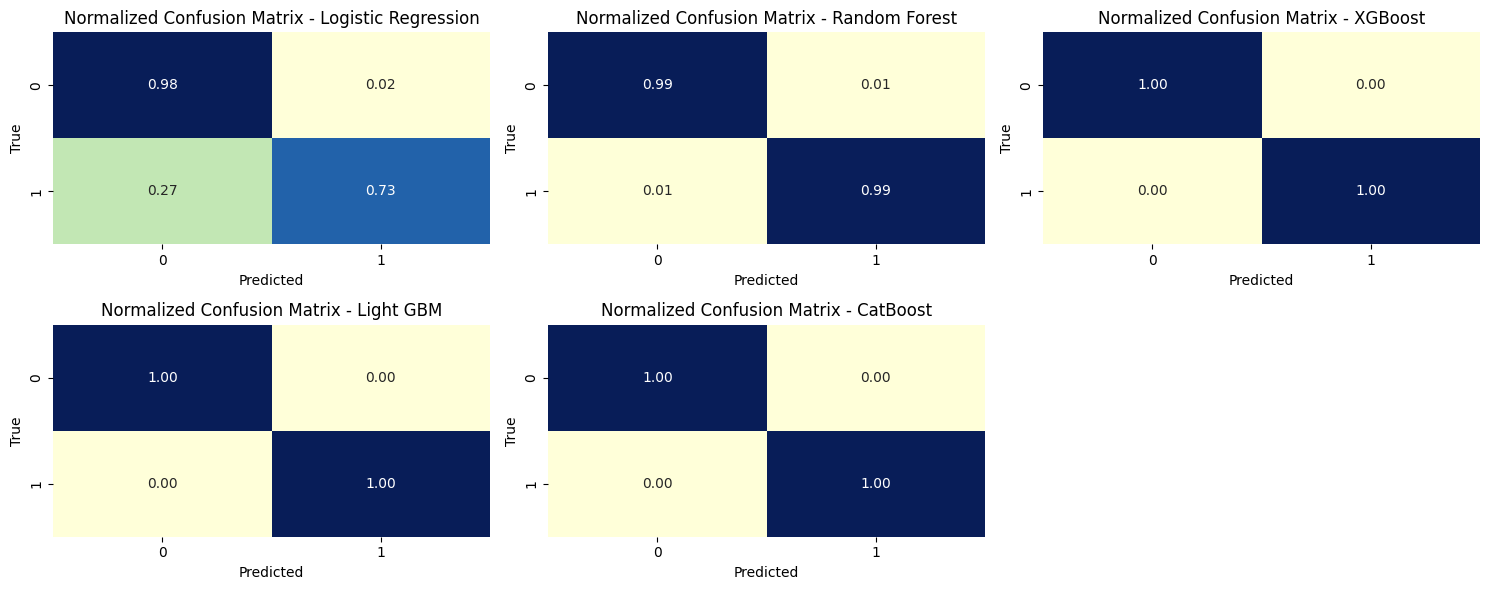

In [ ]:
# Plot the confusion matrices using heatmaps
plt.figure(figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)
for i, (clf_name, cm) in enumerate(confusion_matrices.items()):
    normalized_cm = cm / cm.sum(axis=1, keepdims=True)  # Normalize the confusion matrix
    plt.subplot(2, 3, i + 1)
    sns.heatmap(normalized_cm, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
    plt.title(f"Normalized Confusion Matrix - {clf_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
plt.tight_layout()
plt.show()




In [ ]:
for clf_name, cm in confusion_matrices.items():
    normalized_cm = cm / cm.sum(axis=1, keepdims=True)  # Normalize the confusion matrix
    print(f"Normalized Confusion Matrix - {clf_name}:")
    print(normalized_cm)
    print()

Normalized Confusion Matrix - Logistic Regression:
[[0.98223135 0.01776865]
 [0.27000671 0.72999329]]

Normalized Confusion Matrix - Random Forest:
[[0.99232528 0.00767472]
 [0.01156341 0.98843659]]

Normalized Confusion Matrix - XGBoost:
[[9.98003857e-01 1.99614278e-03]
 [7.82822635e-04 9.99217177e-01]]

Normalized Confusion Matrix - Light GBM:
[[0.99743381 0.00256619]
 [0.00192351 0.99807649]]

Normalized Confusion Matrix - CatBoost:
[[0.99774764 0.00225236]
 [0.00301946 0.99698054]]



Logistic Regression achieved a high accuracy of 98.22% for the first class (true negatives) but had a lower accuracy of 73.00% for the second class (true positives).

Random Forest demonstrated strong performance with 99.23% accuracy for the first class and 98.84% accuracy for the second class.

XGBoost showcased excellent results with 99.80% accuracy for the first class and 99.92% accuracy for the second class, indicating high precision in both classes.

Light GBM exhibited a high accuracy of 99.74% for the first class and 99.81% accuracy for the second class, with relatively low misclassification rates for both classes.

CatBoost demonstrated a high accuracy of 99.77% for the first class and 99.69% accuracy for the second class, suggesting strong overall performance.

In summary, all models showed strong performance in correctly predicting the first class, while XGBoost, Light GBM, and CatBoost outperformed the others in accurately predicting the second class.






**K-fold cross validation**

let's apply cross validation and see the performance of the models.

In [ ]:
classifiers_loans_cv = [
    ("Random Forest", RandomForestClassifier(class_weight="balanced")),
    (
        "XGBoost",
        xgb.XGBClassifier(
            objective="binary:logistic",
            use_label_encoder=False,
            scale_pos_weight=(1 - y.mean()) / y.mean()
        ),
    ),
    ("Light GBM", lgb.LGBMClassifier(class_weight="balanced", verbosity=-1)),
    ("CatBoost", CatBoostClassifier(iterations=10, loss_function='Logloss', verbose=0, class_weights=[1, 1/y.mean()]))
]


In [ ]:
results=evaluate_classifiers(classifiers_loans_cv , X_train, y_train, X_test, y_test)

In [ ]:
results

,Classifier,Fit Time,ROC AUC,F1 Score,Precision,Recall
0,Random Forest,170.231098,0.989228,0.952220,0.920680,0.985999
1,XGBoost,151.212104,0.998876,0.988283,0.976987,0.999843
2,Light GBM,10.729548,0.998024,0.979222,0.959475,0.999799
3,CatBoost,3.060637,0.994784,0.947266,0.900304,0.999396


Observation:

Random Forest achieved a high ROC AUC of 0.9892, indicating good discrimination power. It also obtained a high F1 score of 0.9522, indicating a balance between precision and recall. The precision and recall values were also high, indicating accurate classification of both classes.

XGBoost showed excellent performance with a high ROC AUC of 0.9989 and a high F1 score of 0.9883. It achieved high precision and recall values, indicating accurate predictions for both classes.
Light GBM demonstrated a high ROC AUC of 0.9980 and a respectable F1 score of 0.9792. It achieved a high precision value, indicating accurate positive predictions, and a high recall value, suggesting minimal false negatives.

CatBoost showed a good ROC AUC of 0.9948 and a decent F1 score of 0.9473. The precision value was relatively lower compared to the other models, indicating a higher false positive rate, while the recall value was high, indicating accurate positive predictions.


In summary, all models performed well in terms of ROC AUC, F1 score, precision, and recall. XGBoost and Light GBM stood out with excellent performance across all metrics. Random Forest also delivered strong results, while CatBoost showed slightly lower precision but still achieved a high recall value.

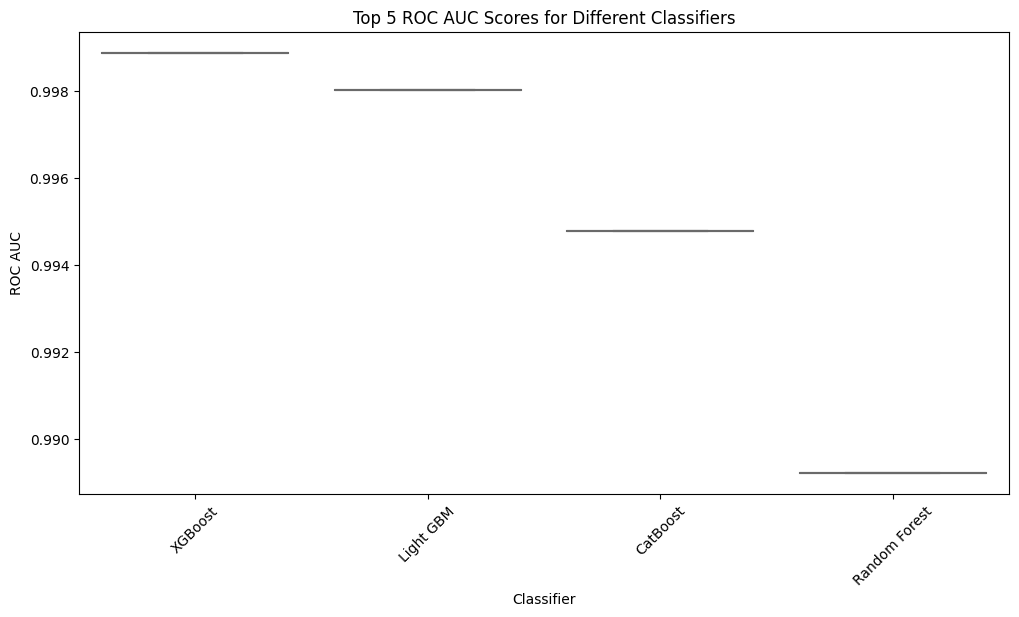

In [ ]:
# Sort the results by ROC AUC in descending order
top_scores = results.sort_values(by="ROC AUC", ascending=False).head(5)

# Box plot of top 5 ROC AUC scores
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_scores, x="Classifier", y="ROC AUC", palette="Set3")
plt.xlabel('Classifier')
plt.ylabel('ROC AUC')
plt.title('Top 5 ROC AUC Scores for Different Classifiers')
plt.xticks(rotation=45)
plt.show()






**Hyperparameters:**

**Logistic Regression:**

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
import optuna
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    # Calculate class weights
    # Calculate class weights
    class_weight = len(y_train) / (2 * np.bincount(y_train))
    class_weight = class_weight[1] / class_weight[0]  # Only consider the positive class weight

    # Create and train the XGBoost classifier with class weights
    model = XGBClassifier(**params, scale_pos_weight=class_weight)
    model.fit(X_train, y_train)

    # Calculate the evaluation metric (e.g., ROC AUC) on the validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    metric = roc_auc_score(y_val, y_pred)

    return metric



In [ ]:
from xgboost import XGBClassifier

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)

best_params = study.best_params
best_score = study.best_value


[I 2023-07-08 07:14:14,579] A new study created in memory with name: no-name-1c27541a-04a3-4b68-b9c7-42a70a8d34e5
[I 2023-07-08 07:15:43,155] Trial 0 finished with value: 0.9969806738503438 and parameters: {'max_depth': 9, 'learning_rate': 0.0672941296576351, 'n_estimators': 33, 'subsample': 0.9507032131852521, 'colsample_bytree': 0.5659124178152762}. Best is trial 0 with value: 0.9969806738503438.
[I 2023-07-08 07:17:16,569] Trial 1 finished with value: 0.9964158199375995 and parameters: {'max_depth': 8, 'learning_rate': 0.010353666383960857, 'n_estimators': 50, 'subsample': 0.5310687957172727, 'colsample_bytree': 0.5046278766287408}. Best is trial 0 with value: 0.9969806738503438.
[I 2023-07-08 07:18:35,854] Trial 2 finished with value: 0.9970672307446937 and parameters: {'max_depth': 8, 'learning_rate': 0.04610481808364893, 'n_estimators': 39, 'subsample': 0.8667516083418576, 'colsample_bytree': 0.683389341387374}. Best is trial 2 with value: 0.9970672307446937.
[I 2023-07-08 07:20:

In [ ]:
print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'max_depth': 10, 'learning_rate': 0.03864609823818308, 'n_estimators': 50, 'subsample': 0.8626673671475056, 'colsample_bytree': 0.5419972610184616}
Best score: 0.9974696797751059


In [ ]:
# Calculate class weights
class_weight = len(y_train) / (1*np.bincount(y_train))
class_weight = class_weight[1] / class_weight[0] # Only consider the positive class weight

# Build the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective="reg:logistic",
    use_label_encoder=False,
    scale_pos_weight=class_weight,
    **best_params,
    random_state=41
)


xgb_classifier.fit(X_train, y_train)


predictions = xgb_classifier.predict(X_test)


In [ ]:
probabilities = xgb_classifier.predict_proba(X_test)

print("Predictions:", predictions)
print("Probabilities:", probabilities)

Predictions: [0 0 0 ... 0 0 0]
Probabilities: [[0.9293598  0.07064021]
 [0.9293598  0.07064021]
 [0.9268645  0.0731355 ]
 ...
 [0.6603539  0.33964607]
 [0.7017901  0.29820994]
 [0.9300623  0.06993774]]


The XGBoost classifier predicted that all instances in the test data belong to the negative class. The predicted probabilities also suggest that the classifier was quite confident in these predictions, as it assigned higher probabilities to the negative class for most instances

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

positive_probabilities = probabilities[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, positive_probabilities)

# Calculate average precision score (PR-AUC)
avg_precision = average_precision_score(y_test, positive_probabilities)

# Print the scores with 3 decimal places
print("ROC-AUC:", round(roc_auc, 3))
print("PR-AUC:", round(avg_precision, 3))


ROC-AUC: 0.863
PR-AUC: 0.433


In summary, the model shows a moderate to good ability to differentiate between classes based on the ROC-AUC score.

 However, the PR-AUC score suggests that the model may have challenges in maintaining a balance between precision and recall, resulting in a lower performance in terms of correctly identifying positive instances.


The PR-AUC value of 0.433 indicates a relatively low precision-recall trade-off for the model. PR-AUC measures the trade-off between precision (the ability to correctly identify positive instances) and recall (the ability to find all positive instances). Higher PR-AUC values indicate better precision-recall trade-off and overall model performance.

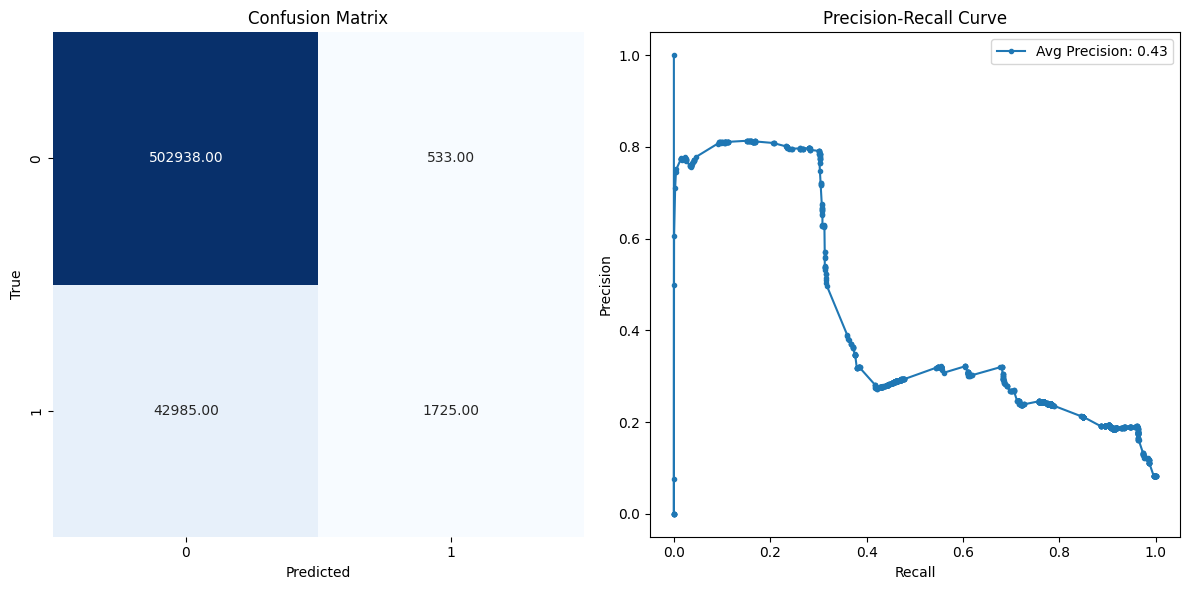

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

cm = confusion_matrix(y_test, predictions)
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, probabilities[:, 1])

# Calculate average precision score
avg_precision = average_precision_score(y_test, probabilities[:, 1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix')

axs[1].plot(recall, precision, marker='.')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend([f'Avg Precision: {avg_precision:.2f}'], loc='upper right')

plt.tight_layout()
plt.show()


The model demonstrated relatively good performance in terms of correctly classifying negative instances, as indicated by the high number of true negatives.

 However, there were some false positive and false negative predictions. The precision-recall curve showed a trade-off between precision and recall, with precision initially decreasing and then increasing again as the classification threshold changed.

 The average precision score of 0.43 provides an overall assessment of the model's precision.



### Threshold adjustment

In [ ]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds, avg_precision, ax):
    ax.plot(thresholds, precisions[:-1], '#124984', linewidth=2, label='Precision')
    ax.plot(thresholds, recalls[:-1], '#8a0b25', linewidth=2, label='Recall')
    ax.plot([0, 1], [avg_precision, avg_precision], 'r--', label='Average Precision')
    ax.legend(loc='lower left')
    ax.axvline(x=0.5, ymin=0, ymax=1, linestyle="dashed", color='grey')
    ax.text(
        x=0.5,
        y=0.35,
        s='Current threshold',
        horizontalalignment="center",
        color="black",
        rotation=90,
        alpha=1,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=1, edgecolor="none"),
    )
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))


### Threshold plt

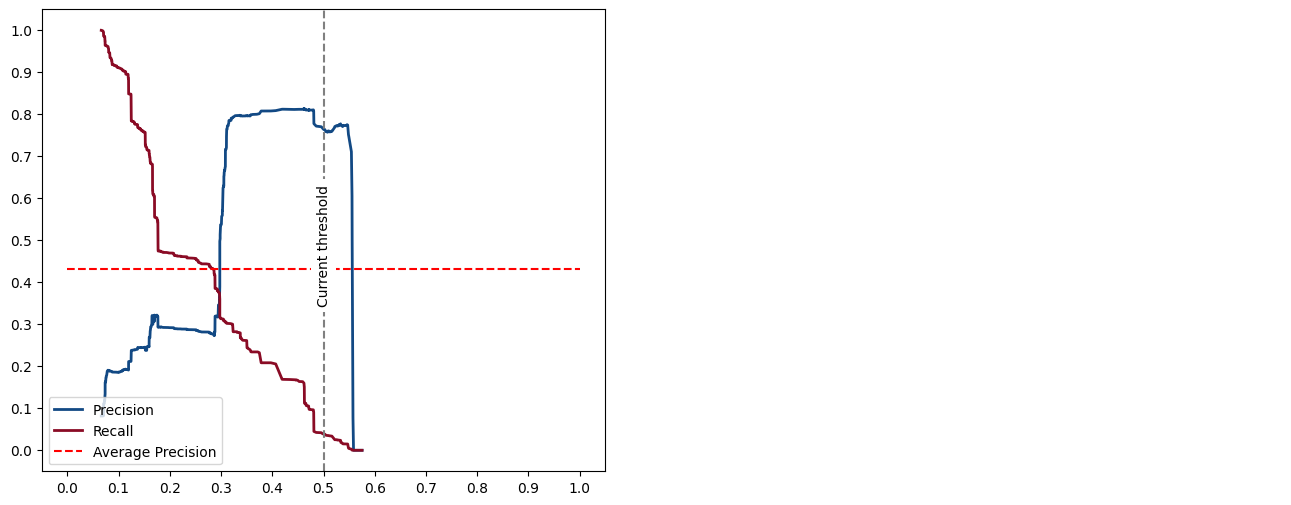

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

precision, recall, threshold = precision_recall_curve(y_test, probabilities[:, 1], pos_label=1)
avg_precision = average_precision_score(y_test, probabilities[:, 1])

plot_prec_recall_vs_tresh(precision, recall, threshold, avg_precision, ax[0])

ax[1].axis("off")
plt.show()




The plot showcases the relationship between precision, recall, and the classification threshold. The x-axis represents the threshold values ranging from 0 to 1, while the y-axis represents the precision and recall values.

Recall: The recall (sensitivity) starts at 1 on the y-axis and decreases gradually to around 0.6 on the x-axis. This suggests that as the threshold increases, the model becomes more conservative in making positive predictions, resulting in a lower recall value.

Precision: The precision starts at 0 on the x-axis and gradually increases to around 0.8 on the y-axis. However, it then decreases again to around 0.6 on the x-axis. This pattern indicates that as the threshold increases, the model becomes more cautious in making positive predictions, leading to higher precision. However, as the threshold continues to increase, precision decreases due to the reduction in the number of positive predictions.

Average Precision: The average precision score is reported as 0.45, representing the overall performance of the model in terms of precision across various recall levels.

In summary, the precision-recall trade-off analysis reveals that as the threshold increases, the model becomes more conservative in making positive predictions, resulting in a lower recall and higher precision. However, there is a threshold point beyond which precision starts to decline again due to the reduced number of positive predictions. The average precision score of 0.45 suggests moderate overall performance in terms of precision.

**Feature imoportance**

100%|===================| 2192523/2192722 [131:48<00:00]       

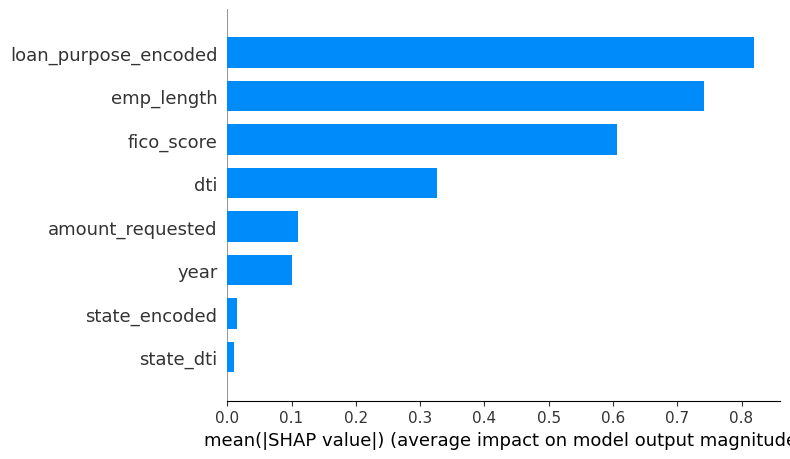

In [ ]:
import shap
explainer = shap.Explainer(xgb_classifier, X_train)

# Calculate SHAP values for all features
shap_values = explainer.shap_values(X_train)

# Summarize the SHAP values
shap.summary_plot(shap_values, X_train, plot_type='bar')


## **Conclusion:**



The dataset showed an imbalance between the "rejected" and "accepted" loan classes, with 91.81% in the "rejected" class and 8.19% in the "accepted" class.

Logistic Regression, Random Forest, XGBoost, Light GBM, and CatBoost models were used for prediction. With class weights, the Random Forest, XGBoost, Light GBM, and CatBoost models outperformed Logistic Regression.

Through k-fold cross-validation, the Random Forest model initially performed the best. However, after hyperparameter tuning, XGBoost emerged as the top-performing model.

Evaluation metrics, such as confusion matrices, precision-recall curves, and average precision scores, were used to assess model performance. XGBoost consistently demonstrated the highest performance across these metrics.

Feature importance analysis using XGBoost identified the most influential features for loan acceptance or rejection.

In summary, the XGBoost model with optimized hyperparameters proved to be the best model for predicting loan acceptance or rejection. Further refinement and addressing the class imbalance issue may be necessary for enhanced performance.

**Loan ranking - grade, sub-grade & interest rate**

---



Loan grade determines the interest rate and fees. Lending Club’s interest rates take into account credit risk and market conditions. The final interest rate for each loan grade is the result of the following equation: Lending Club Base Rate + Adjustment for Risk & Volatility. The Adjustment for Risk & Volatility is designed to cover expected losses and provide higher risk-adjusted returns for each loan grade increment from A1 to G5.